# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Log odds

When I was in grad school, I signed up for a class on Theory of Computation. 
On the first day of class, I was the first to arrive. A few minutes later, another student arrived. Because I was expecting most students in an advanced computer science class to be male, I was mildly surprised that the other student was female. 

Another female student arrived a few minutes later, which was sufficiently surprising that I started to think I was in the wrong room. When another female student arrived, I was confident I was in the wrong place, and it turned out I was.

As each student arrived, I used the observed data to update my belief that I was in the right place. We can use Bayes's Rule, which we saw in Chapter 5, to quantify the calculation I was doing intuitively.

I'll use $H$ to represent the hypothesis that I was in the right room, and $F$ to represent the observation that the first other student was female. Bayes's Rule gives us:

$O(H|F) = O(H) \frac{P(F|H)}{P(F|not H)}$

Before I saw the other students, I was confident I was in the right room, so I might assign prior odds of 10:1 in favor:

$O(H) = 10$

When I was in grad school, most advanced computer science classes were about 90% male, so if I was in the right room, the likelihood of the first female student was only 10%.

If we don’t assume I was in the right room, then the likelihood of the first female student was more like 50%, so the likelihood ratio is 1/5.

$O(H|F) = O(H) / 5 = 2$

After the first student, the posterior odds are 2:1 I was in the right room, or 66%.  After two students:

$O(H|FF) = O(H) / 25 = 2/5$

Which corresponds to probability 2/7.  And after three students:

$O(H|FFF) = 2/25$

At that point, I was right to believe I was in the wrong room.



Now let's see what those odds look like in terms of probability:

In [4]:
def prob(odds):
    return odds / (odds + 1)

In [5]:
index = ['prior', '1 student', '2 students', '3 students']

table = pd.DataFrame(index=index)
table['odds'] = [10, 2, 2/5, 2/25]
table['prob'] = prob(table['odds'])

table

,odds,prob
prior,10.00,0.909091
1 student,2.00,0.666667
2 students,0.40,0.285714
3 students,0.08,0.074074


Each update uses the same likelihood, but the changes in probability are not the same.  The first update decreases the probability by about 24 percentage points, the second by 38, and the third by 21.

That's normal for this kind of update, and in fact it's necessary; if the changes were the same size, we would quickly get negative probabilities.

In [6]:
table['prob'].diff()

prior              NaN
1 student    -0.242424
2 students   -0.380952
3 students   -0.211640
Name: prob, dtype: float64

The odds make a more obvious pattern.  Because each update multiplies the odds by the same likelihood ratio, the odds form a geometric sequence.

And that brings us to consider another way to represent uncertainty: **log odds**, which is the logarithm of odds, usually expressed using the natural log (base $e$).

Adding log odds to the table:

In [7]:
table['log odds'] = np.log(table['odds'])
table

,odds,prob,log odds
prior,10.00,0.909091,2.302585
1 student,2.00,0.666667,0.693147
2 students,0.40,0.285714,-0.916291
3 students,0.08,0.074074,-2.525729


You might notice:

* When probability is greater than 0.5, odds are greater than 1, and log odds are positive.

* When probability is less than 0.5, odds are less than 1, and log odds are negative.

And you might also notice that the log odds are equally spaced.

In [8]:
table['log odds'].diff()

prior              NaN
1 student    -1.609438
2 students   -1.609438
3 students   -1.609438
Name: log odds, dtype: float64

The change in log odds after each update is the logarithm of the likelihood ratio.

In [9]:
np.log(1/5)

-1.6094379124341003

That's true in this example, and we can show that it's true in general by taking the log of both sides of Bayes's Rule.

$ \log O(H|F) = \log O(H) + \log \frac{P(F|H)}{P(F|not H)}$

On a log odds scale, a Bayesian update is additive.  So if $F^x$ means that $x$ female students arrive while I am waiting, the posterior log odds that I am in the right room are:

$ \log O(H|F^x) = \log O(H) + x \log \frac{P(F|H)}{P(F|not H)}$

This equation represents a linear relationship between the evidence and the posterior log odds.  In this example it is literally true, but even when it's not, it is common to use a linear function to model the relationship between an explanatory variable, $x$, and a dependent variable expressed in log odds.

$ \log O(H | x) = \beta_0 + \beta_1 x$

where $\beta_0$ and $\beta_1$ are unknown parameters:

* The intercept, $\beta_0$, is the log odds of the hypothesis when $x$ is 0.

* The slope, $\beta_1$, is the log of the likelihood ratio.

This equation is the basis of logistic regression.

## The Space Shuttle problem

As an example of logistic regression, I'll solve a problem from Cameron Davidon-Pilon's book, [Bayesian Methods for Hackers](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb).  He writes:

> "On January 28, 1986, the twenty-fifth flight of the U.S. space shuttle program ended in disaster when one of the rocket boosters of the Shuttle Challenger exploded shortly after lift-off, killing all seven crew members. The presidential commission on the accident concluded that it was caused by the failure of an O-ring in a field joint on the rocket booster, and that this failure was due to a faulty design that made the O-ring unacceptably sensitive to a number of factors including outside temperature. Of the previous 24 flights, data were available on failures of O-rings on 23, (one was lost at sea), and these data were discussed on the evening preceding the Challenger launch, but unfortunately only the data corresponding to the 7 flights on which there was a damage incident were considered important and these were thought to show no obvious trend."

The dataset is originally from [this paper](https://amstat.tandfonline.com/doi/abs/10.1080/01621459.1989.10478858), but we can download it from Davidson-Pilon's site.

In [195]:
import os

if not os.path.exists('challenger_data.csv'):
    !wget https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv

I'll read the dataset and do a little cleaning.

In [196]:
data = pd.read_csv('challenger_data.csv', parse_dates=[0])

# avoiding column names with spaces
data.rename(columns={'Damage Incident': 'Damage'}, inplace=True)

# dropping row 3, in which Damage Incident is NaN,
# and row 24, which is the record for the Challenger
data.drop(labels=[3, 24], inplace=True)

# sort by temperature
data.sort_values(by='Temperature', inplace=True)

data

,Date,Temperature,Damage
14,1985-01-24,53,1
9,1984-02-03,57,1
23,1986-01-12,58,1
10,1984-04-06,63,1
0,1981-04-12,66,0
15,1985-04-12,67,0
13,1984-11-08,67,0
5,1983-04-04,67,0
4,1982-01-11,68,0
2,1982-03-22,69,0


The original dataset contains the number of damage incidents, but for this analysis, we'll treat the outcome as a binary value: `1` if there was any damage and `0` if not.

In [197]:
data['y'] = (data['Damage'] == '1').astype(int)
data['y'].sum()

7

Here's a representation of the relationship between damage and temperature.

In [366]:
def plot_data(data):
    """Plot damage as a function of temperature.
    
    data: DataFrame
    """
    plt.plot(data['Temperature'], data['y'], 'o', 
             color="C1", alpha=0.5)

    decorate(ylabel="Probability of damage",
         xlabel="Outside temperature (deg F)",
         title="Damage to O-Rings vs Temperature")

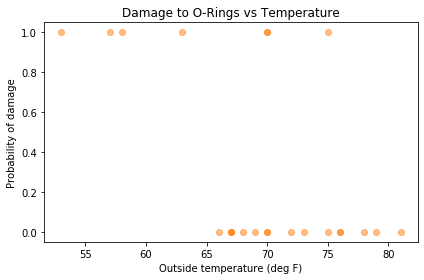

In [367]:
plot_data(data)

When the outside temperature was below 65 degrees, there was always damage to the O-rings.  When the temperature was about 65 degrees, there was usually no damage.  

Based on this figure, it seems plausible that the probability of damage is related to temperature.  If we assume this probability follows a logistic model, we can write:

$ \log O(H | x) = \beta_0 + \beta_1 x$

where $H$ is the hypothesis that the O-rings will be damaged, $x$ is temperature, and $\beta_0$ and $\beta_1$ are the parameters we will estimate. 

For reasons I'll explain soon, I'll define $x$ to be temperature shifted by an offset so its mean is 0.

In [368]:
offset = data['Temperature'].mean()
data['x'] = data['Temperature'] - offset

Before doing a Bayesian update, I'll use `StatsModels` to run logistic regression.

In [369]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=data).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.441635
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:                          Logit   Df Residuals:                       21
Method:                           MLE   Df Model:                            1
Date:                Sun, 02 Aug 2020   Pseudo R-squ.:                  0.2813
Time:                        19:35:15   Log-Likelihood:                -10.158
converged:                       True   LL-Null:                       -14.134
Covariance Type:            nonrobust   LLR p-value:                  0.004804
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1076      0.580     -1.911      0.056      -2.244       0.028
x             -0.2322      0.108     -2.145      0.032      -0.444      -0.020
==============================================================================
"""

The result is a "point estimate" for the parameters, that is, a single value rather than a posterior distribution.

To see what these parameters mean, I'll use them to compute probabilities for a range of temperatures.

In [370]:
inter = -1.1
slope = -0.23
xs = np.arange(53, 83) - offset

We can use the logistic regression equation to compute log odds:

In [371]:
log_odds = inter + slope * xs

And then convert to probabilities.

In [372]:
odds = np.exp(log_odds)
ps = odds / (odds + 1)
ps.mean()

0.4153169290226892

The function that converts from log odds to probabilities has a name, `expit`, and SciPy provides an implementation.

In [373]:
from scipy.special import expit

ps = expit(inter + slope * xs)
ps.mean()

0.4153169290226892

Here's what the logistic model looks like with these estimated parameters.

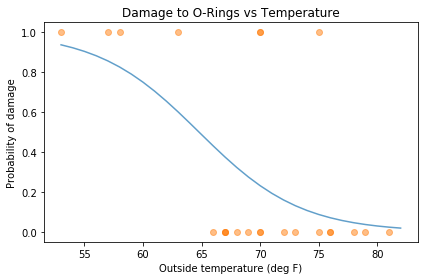

In [374]:
plt.plot(xs+offset, ps, color='C0', alpha=0.7)

plot_data(data)

At low temperatures, the probability of damage is high; at high temperatures, it drops off to near 0.

## Likelihood

To demonstrate the likelihood function, let's assume temporarily that the estimated parameters are correct and compute the likelihood of the data.

I'll use the model to compute the probability of damage for each launch temperature in the dataset.

In [375]:
xs = data['x']
ps = expit(inter + slope * xs)

For each launch where damage was detected, the probability of that outcome was $p$, according to the model.  For each launch with no damage, the probability of that outcome was $1-p$.

So we can use `np.where` to compute the probability of each point in the dataset.

In [376]:
ys = data['y']
likes = np.where(ys, ps, 1-ps)
likes

array([0.93761415, 0.85692728, 0.82635335, 0.60108788, 0.56954622,
       0.62480647, 0.62480647, 0.62480647, 0.67699586, 0.7251195 ,
       0.23147522, 0.76852478, 0.76852478, 0.23147522, 0.840238  ,
       0.86875553, 0.91293423, 0.08706577, 0.92956327, 0.92956327,
       0.95434883, 0.96338517, 0.97656933])

Then the probability of the data is the product of that array of probabilities.

In [377]:
likes.prod()

3.877150978524181e-05

That's how we compute the likelihood of the data for a particular pair of parameters.  Now all we need is a prior distribution.

## Prior distribution

I'll use uniform distributions for both parameters, using the estimated parameters from the previous section to help me locate the grid.

In [378]:
inters = np.linspace(-5, 1, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [379]:
slopes = np.linspace(-0.8, 0.1, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

We can use `make_joint` to construct the joint prior distribution.

In [380]:
from utils import make_joint

In [381]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.00,-4.88,-4.76,-4.64,-4.52,-4.40,-4.28,-4.16,-4.04,-3.92,...,-0.08,0.04,0.16,0.28,0.40,0.52,0.64,0.76,0.88,1.00
Slope,,,,,,,,,,,,,,,,,,,,,
-0.800,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.782,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.764,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.746,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
-0.728,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


The values of `slope` run down the rows; the values of `intercept` run across the columns.

For this problem, it will be convenient to "stack" the prior so the parameters are levels in a `MultiIndex`. 

In [382]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
-0.8   -5.00        1.0
       -4.88        1.0
       -4.76        1.0
       -4.64        1.0
       -4.52        1.0
dtype: float64

`joint_pmf` is a `Pmf` with a two levels in the index, one for each parameter.  That makes it easy to loop through possible pairs of parameters, as in this likelihood function.

In [383]:
def likelihood_logistic(joint_pmf, data):
    """Likelihood of the data for each pair of parameters.
    
    joint_pmf: Pmf with a two-level index
    data: DataFrame with columns `x` and `y`
    
    returns: DataFrame, same shape as joint_pmf
    """
    likelihood = joint_pmf.copy()

    ys = data['y']
    xs = data['x']

    for slope, inter in joint_pmf.index:
        ps = expit(inter + slope * xs)
        likes = np.where(ys, ps, 1-ps)
        likelihood.loc[slope, inter] = likes.prod()
        
    return likelihood

The loop iterates through the parameters.  For each possible pair, it uses the logistic model to compute `ps`, then computes the likelihood of the data.

The last line of the loop uses `loc` to assign the result to the right row in `likelihood`.

In [384]:
likelihood = likelihood_logistic(joint_pmf, data)
likelihood.sum()

0.007458138027414907

The result is a `Pmf` with the same shape and index as `joint_pmf`, so we can compute the posterior distribution in the usual way.

In [385]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

0.007458138027414907

Because we used a uniform prior, the parameter pair with the highest likelihood is also the pair with maximum posterior probability:

In [386]:
posterior_pmf.max_prob()

(-0.242, -1.1600000000000001)

So we can confirm that the results of the Bayesian update are consistent with the maximum likelihood estimate computed by StatsModels, within the precision of the grid we're using.

If we unstack the posterior `Pmf` we can make a contour plot of the posterior distribution.

In [342]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

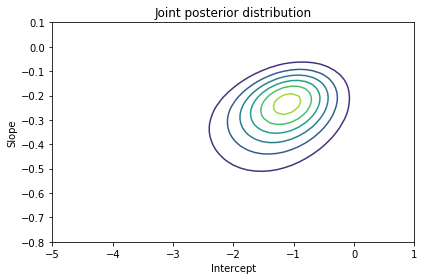

In [344]:
joint_posterior = posterior_pmf.unstack()
plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

And we can extract the posterior marginal distributions:

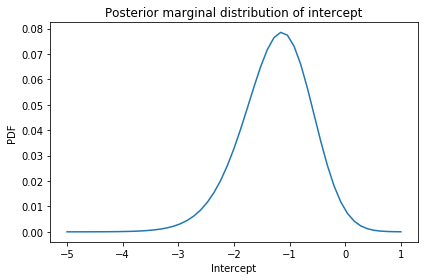

In [345]:
from utils import marginal

marginal_inter = marginal(joint_posterior, 0)
marginal_inter.plot()

decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

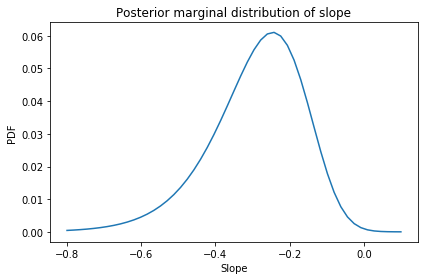

In [346]:
marginal_slope = marginal(joint_posterior, 1)
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

This contour demonstrates one of the reasons I defined `x` to be 0 when temperature is 70 degrees F; that way, there is almost no correlation between the estimated slope and intercept, which we can see because the contours are almost circular.

To see why this matters, go back and set `offset=0` and run this analysis again.  You'll have to adjust the prior distribution of `intercept`.

The contours you get will be elongated, indicating a correlation between the estimated slope and intercept.  This correlation is not a problem in theory, but in practice it makes grid algorithms less effective.

## Transforming distributions

Let's interpret these parameters.  Recall that the intercept is the log odds of the hypothesis when $x$ is 0, which is when temperature is about 70 degrees F.

In [347]:
offset

69.56521739130434

To convert from log odds to probabilities, I'll use the following function, which transforms the quantities in a `Pmf` by applying a function:

In [348]:
def transform(pmf, func):
    """Transform the quantities in a Pmf.
    
    pmf: Pmf object
    func: function object
    
    returns: Pmf
    """
    ps = pmf.ps
    qs = func(pmf.qs)
    return Pmf(ps, qs)

If we call `transform` and pass `expit` as a parameter, it tranforms the log odds in `marginal_inter` into probabilities and returns a marginal posterior distribution of probabilities.

In [349]:
marginal_probs = transform(marginal_inter, expit)

Here's the posterior distribution for the probability of damage at 70 degrees F.

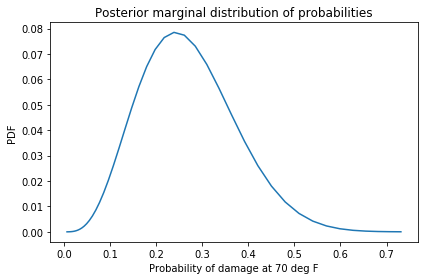

In [350]:
marginal_probs.plot()

decorate(xlabel='Probability of damage at 70 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of probabilities')

The mean of this distribution is about 24%.

In [351]:
marginal_probs.mean()

0.24010057981575336

This result shows the second reason I defined `x` to be zero when temperature is 70 degrees F; that way, we use the intercept to compute the probability of damage at a relevant temperature, rather than 0 degrees F.

Now let's look more closely at the estimated slope.  In the logistic model, the parameter $\beta_1$ is the log of the likelihood ratio.  So we can use `exp` to transform the marginal distribution of slope into the marginal distribution of likelihood ratio.

In [352]:
marginal_lr = transform(marginal_slope, np.exp)

Here's what it looks like.

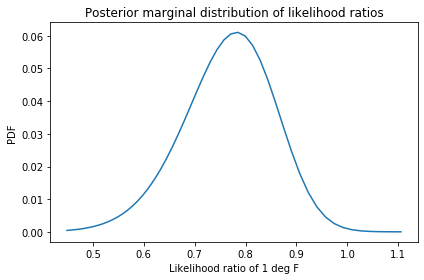

In [353]:
marginal_lr.plot()

decorate(xlabel='Likelihood ratio of 1 deg F',
         ylabel='PDF',
         title='Posterior marginal distribution of likelihood ratios')

The mean of this distribution is about 0.75:

In [354]:
mean_lr = marginal_lr.mean()
mean_lr

0.7542582027673367

Which means that each additional degree Fahrenheit provides evidence against the possibility of damage, with a likelihood ratio (Bayes factor) of 0.75.

In this section:

* I computed the posterior mean of the probability of damage at 70 deg F by transforming the marginal distribution of the intercept to the marginal distribution of probability, and then computing the mean.

* I computed the posterior mean of the likelihood ratio by transforming the marginal distribution of slope to the marginal distribution of likelihood ratios, and then computing the mean.

This is the correct order of operations, as opposed to computing the posterior means first and then transforming them.  


**Exercise:** To see the difference, compute both values the other way around; that is: 

* Compute the posterior mean of the intercept and then transform it to a probability.

* Compute the posterior mean of the slope and then transform it to a likelihood ratio.

In this example, the difference is not huge, but it is a difference.  As a general rule, transform first, before computing summary statistics.

In [248]:
# Solution

expit(marginal_inter.mean())

0.22265606454626985

In [249]:
# Solution

np.exp(marginal_slope.mean())

0.7483750621480612

## Predictive distributions

In the logistic model, the parameters are interpretable, at least with some manipulation.  But often what we really care about are predictions, not parameters.  In the Space Shuttle problem, the most important prediction is, "What is the probability of O-ring damage if the external temperature is 31 degrees F?"

To make that prediction, I'll draw a sample of parameter pairs from the posterior distribution.

In [388]:
sample = posterior_pmf.sample(101)
sample.shape

(101,)

In [389]:
sample.dtype

dtype('O')

In [390]:
type(sample[0])

tuple

The result is an array of 101 tuples, each representing a possible pair of parameters.

The following function takes this sample and a range of `xs`, and returns an array of predicted probabilities.

In [391]:
def make_predictions(xs, sample):
    pred = np.empty((len(sample), len(xs)))

    for i, (slope, inter) in enumerate(sample):
        pred[i] = expit(inter + slope * xs)
    
    return pred

Here's a range of temperatures that goes from 31 degrees F, the temperature when the Challenger launched, up to 82 degrees F, highest observed temperature.

In [418]:
temps = np.arange(31, 83)
xs = temps - offset

And here are the predictions.

In [419]:
pred = make_predictions(xs, sample)

The result has one column for each value in `xs` and one row for each element of `sample`.  To get a quick sense of what the predictions look like, we can loop through the rows and plot them.

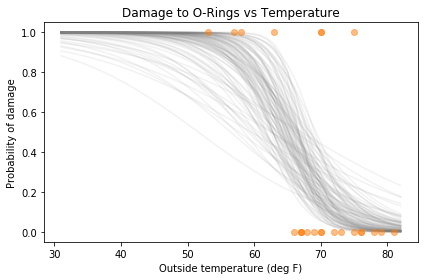

In [420]:
for ps in pred:
    plt.plot(temps, ps, color='gray', alpha=0.1)
    
plot_data(data)

The overlapping lines in this figure give a sense of the most likely value at each temperature and the degree of uncertainty.

To quantify the central tendency, we can compute the median in each column, and to quantify the uncertainty, we can compute a 90% credible interval.

`np.percentile` computes the given percentiles; with the argument `axis=0`, it computes those percentiles in each column.

In [421]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(52,)

The result is three arrays contains predicted probabilities for the lower bound of the 90% CI, the median, and the upper bound of the CI.

Here's what they look like:

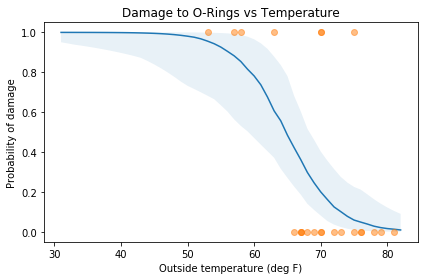

In [415]:
plt.fill_between(temps, low, high, alpha=0.1)
plt.plot(temps, median, color='C0')

plot_data(data)

According to these results, the probability of damage to the O-rings at 80 degrees F is near 2%, but there is some uncertainty about that prediction; the upper bound of the CI is at 12%.

In [422]:
low = pd.Series(low, temps)
median = pd.Series(median, temps)
high = pd.Series(high, temps)

In [424]:
t = 80
median[t], low[t], high[t]

(0.016344387144808577, 0.0013007946886424474, 0.1219692080774154)

At 60 degrees, the probability of damage is near 78%, but the CI is even wider, from 47% to 97%.

In [425]:
t = 60
median[t], low[t], high[t]

(0.7815603523114565, 0.4704691918433355, 0.9652838561890265)

But the primary goal of the model is to predict the probability of damage at 31 degrees F, and the answer is near certainty, at least 95%, and more likely to be more than 99.9%.

In [426]:
t = 31
median[t], low[t], high[t]

(0.9998891205970614, 0.9504317203271019, 0.999999957885326)

One conclusion we might draw from these results is this:  If the people responsible for the Challenger launch had taken into account all of the data, and not just the seven damage incidents, they could have predicted with high confidence that the probability of damage at 31 degrees F was nearly certain.  And in that case, it seems likely they would have postponed the launch.

But if you look again at the previous figure, there is another conclusion I hope you will consider: in this example, we are using a model to make a prediction that extends far beyond the data.  When we extrapolate like that, we have to remember not just the uncertainty quantified by the model, which we expressed as a credible interval; we also have to consider the possibility that the model itself is unreliable.

This example is based on a logistic model, which assumes that each additional degree of temperature contributes the same amount of evidence in favor of (or against) the possibility of damage.  Within a narrow range of temperatures, that might be a reasonable assumption, especially if it is supported by data.  But over a wider range, and beyond the bounds of the data, reality has no obligation to stick to the model.

This issue will come up again in the next example.

## GSS data

As a second example of logistic regression, we'll use data from the [General Social Survey]() (GSS) to describe generational changes in support for legalization of marijuana in the U.S.

The GSS is...

In [45]:
# Load the data file

# TODO: Update this to point to the ThinkBayes2 repo

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [46]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 166)

In [47]:
gss['grass'].value_counts(dropna=False)

NaN    27268
2.0    25662
1.0    11884
Name: grass, dtype: int64

In [48]:
gss['sex'].value_counts(dropna=False)

2    36200
1    28614
Name: sex, dtype: int64

In [49]:
gss['cohort'].describe()

count    64586.000000
mean      1948.846069
std         21.262659
min       1883.000000
25%       1934.000000
50%       1951.000000
75%       1964.000000
max       2000.000000
Name: cohort, dtype: float64

In [50]:
valid = gss.dropna(subset=['grass', 'sex', 'cohort']).copy()
valid.shape

(37427, 166)

In [51]:
valid['y'] = valid['grass'].replace(2, 0)
valid['y'].value_counts()

0.0    25572
1.0    11855
Name: y, dtype: int64

In [52]:
offset = valid['cohort'].mean()
valid['x'] = valid['cohort'] - offset

In [53]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.logit(formula, data=valid).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.582717
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                37427
Model:                          Logit   Df Residuals:                    37425
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Aug 2020   Pseudo R-squ.:                 0.06675
Time:                        13:51:07   Log-Likelihood:                -21809.
converged:                       True   LL-Null:                       -23369.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8491      0.012    -71.017      0.000      -0.873      -0.826
x              0.0317      0.001     52.197      0.000       0.031       0.033
==============================================================================
"""

In [54]:
data = valid.groupby('cohort')['y'].agg(['sum', 'count'])
data

,sum,count
cohort,,
1884.0,0.0,1
1886.0,0.0,3
1887.0,1.0,9
1888.0,0.0,3
1889.0,1.0,14
...,...,...
1996.0,40.0,47
1997.0,28.0,41
1998.0,11.0,17


In [55]:
data['x'] = data.index - offset
data.head()

,sum,count,x
cohort,,,
1884.0,0.0,1,-64.724243
1886.0,0.0,3,-62.724243
1887.0,1.0,9,-61.724243
1888.0,0.0,3,-60.724243
1889.0,1.0,14,-59.724243


In [56]:
def plot_data(data):
    fraction = data['sum'] / data['count']
    plt.plot(data.index, fraction, 'o', color='C1',
                  label='GSS data', alpha=0.3)
    
    decorate(xlabel='Year of birth',
             ylabel='Percent in favor',
             title='Support for legal marijuana vs cohort')

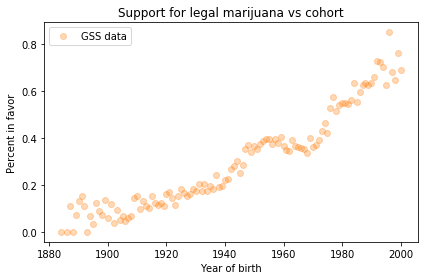

In [57]:
plot_data(data)

In [58]:
inter = -0.85
slope = 0.032

In [59]:
xs = data['x']

ps = expit(inter + slope * xs)
ps

cohort
1884.0    0.051117
1886.0    0.054312
1887.0    0.055979
1888.0    0.057694
1889.0    0.059459
            ...   
1996.0    0.659895
1997.0    0.667039
1998.0    0.674108
1999.0    0.681098
2000.0    0.688008
Name: x, Length: 116, dtype: float64

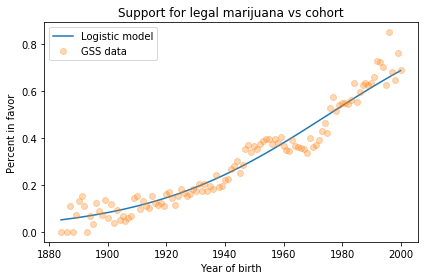

In [60]:
ps.plot(color='C0', label='Logistic model')

plot_data(data)

In [61]:
from scipy.stats import binom

ks = data['sum']
ns = data['count']
likes = binom.pmf(ks, ns, ps)

In [62]:
likes.prod()

1.374180525164937e-209

In [63]:
np.log(likes.prod())

-480.92242686400294

In [64]:
import sys
sys.float_info.min_exp

-1021

In [65]:
inters = np.linspace(-1.0, -0.6, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [66]:
slopes = np.linspace(0.02, 0.04, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

In [67]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-1.000,-0.992,-0.984,-0.976,-0.968,-0.960,-0.952,-0.944,-0.936,-0.928,...,-0.672,-0.664,-0.656,-0.648,-0.640,-0.632,-0.624,-0.616,-0.608,-0.600
Slope,,,,,,,,,,,,,,,,,,,,,
0.0200,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0204,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0208,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0212,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0216,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [68]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.02   -1.000       1.0
       -0.992       1.0
       -0.984       1.0
       -0.976       1.0
       -0.968       1.0
dtype: float64

In [69]:
likelihood = joint_pmf.copy()

xs = data['x']
ks = data['sum']
ns = data['count']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood.loc[slope, inter] = likes.prod()

In [70]:
likelihood.sum()

2.1640938466678573e-208

In [71]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.1640938466678573e-208

In [72]:
posterior_pmf.max_prob()

(0.0316, -0.848)

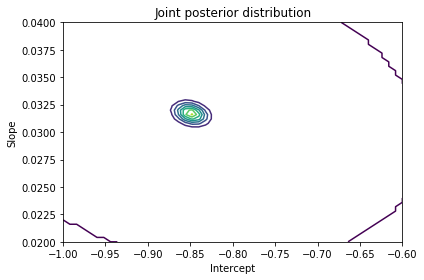

In [73]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [74]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-0.8491556078449897, 0.03169425573731395)

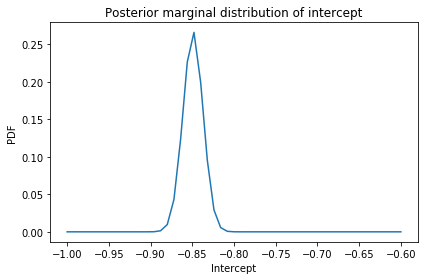

In [75]:
marginal_inter.plot()
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

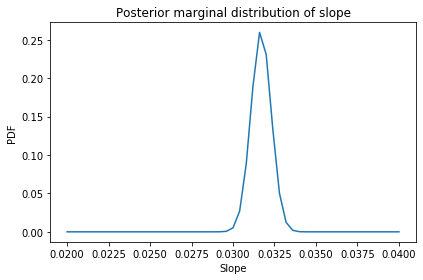

In [76]:
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [77]:
log_likelihood = joint_pmf.copy()

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    log_likes = binom.logpmf(ks, ns, ps)
    log_likelihood.loc[slope, inter] = log_likes.sum()

In [78]:
log_likelihood.max()

-480.8041799824062

In [79]:
likelihood2 = np.exp(log_likelihood - log_likelihood.max())

In [80]:
posterior2_pmf = joint_pmf * likelihood2
posterior2_pmf.normalize()

13.991952835762627

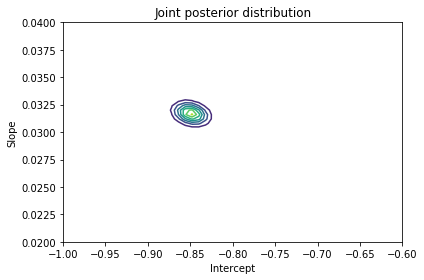

In [81]:
joint_posterior2 = posterior2_pmf.unstack()

plot_contour(joint_posterior2)
decorate(title='Joint posterior distribution')

In [82]:
marginal2_inter = marginal(joint_posterior2, 0)
marginal2_slope = marginal(joint_posterior2, 1)

marginal2_inter.mean(), marginal2_slope.mean()

(-0.8491556078449896, 0.03169425573731394)

In [83]:
marginal_inter.mean(), marginal_slope.mean()

(-0.8491556078449897, 0.03169425573731395)

In [84]:
sample = posterior_pmf.sample(101)
xs = data['x']
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)
    
pred.shape

(101, 116)

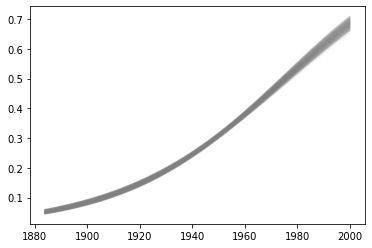

In [85]:
for ps in pred:
    plt.plot(xs+offset, ps, color='gray', alpha=0.1)

In [86]:
low, median, high = np.percentile(pred, [2.5, 50, 97.5], axis=0)
median.shape

(116,)

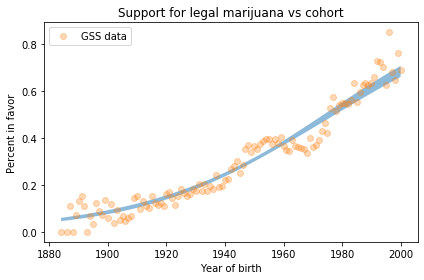

In [87]:
plt.fill_between(xs+offset, low, high, alpha=0.5)

plot_data(data)

## Bayesian regression

This notebook presents a simple example of Bayesian regression using sythetic data

### Data

Suppose there is a linear relationship between `x` and `y` with slope 2 and intercept 1, but the measurements of `y` are noisy; specifically, the noise is Gaussian with mean 0 and `sigma = 0.3`. 

In [88]:
slope = 2
inter = 1
sigma = 0.5

In [89]:
xs = np.linspace(0, 1, 12)

In [90]:
ys = inter + slope * xs + np.random.normal(0, sigma, len(xs))

In [91]:
slope, inter = 2, 1
resid = slope * xs + inter - ys
resid

array([-0.6247126 , -0.07161381,  0.75228894,  0.28565281, -0.7868341 ,
        0.76396562,  0.50799289, -0.20538128, -0.54690981,  0.02247993,
        0.36331752,  0.13050125])

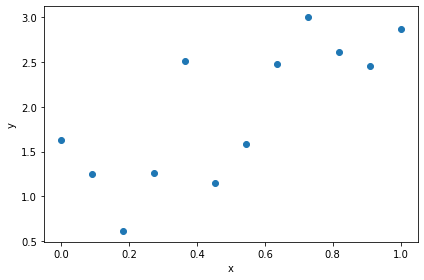

In [92]:
plt.plot(xs, ys, 'o')
decorate(xlabel='x', ylabel='y')

### Grid algorithm

We can solve the problem first using a grid algorithm, with uniform priors for slope, intercept, and sigma.

As an exercise, fill in this likelihood function, then test it using the code below.

Your results will depend on the random data you generated, but in general you should find that the posterior marginal distributions peak near the actual parameters.

In [93]:
slopes = np.linspace(0, 4, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [94]:
inters = np.linspace(0, 3, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [95]:
sigmas = np.linspace(0.01, 2.01, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [96]:
joint = make_joint(prior_slope, prior_inter)
joint.shape

(41, 51)

In [97]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

Slope  Intercept
0.0    0.000        1
       0.075        1
       0.150        1
       0.225        1
       0.300        1
dtype: int64

In [98]:
prior3 = make_joint(prior_sigma, joint_pmf)
prior3.shape

(2091, 31)

In [99]:
slope, inter = 2, 1
resids = (slope * xs + inter) - ys
resids

array([-0.6247126 , -0.07161381,  0.75228894,  0.28565281, -0.7868341 ,
        0.76396562,  0.50799289, -0.20538128, -0.54690981,  0.02247993,
        0.36331752,  0.13050125])

In [100]:
sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resids)
sigma_mesh.shape

(12, 31)

In [101]:
from scipy.stats import norm

densities = norm(0, sigma_mesh).pdf(resid_mesh)
densities.shape

(12, 31)

In [102]:
from scipy.stats import norm

densities = norm.pdf(resid_mesh, 0, sigma_mesh)
densities.shape

(12, 31)

In [103]:
like = densities.prod(axis=0)
like.shape
like

array([0.00000000e+000, 9.22778554e-103, 4.82269540e-027, 3.97305650e-012,
       2.58357202e-007, 1.84468629e-005, 9.75464315e-005, 1.62336349e-004,
       1.53965628e-004, 1.09500744e-004, 6.70284095e-005, 3.80073689e-005,
       2.07969176e-005, 1.12411742e-005, 6.08425048e-006, 3.32364993e-006,
       1.84074492e-006, 1.03610644e-006, 5.93415407e-007, 3.45960926e-007,
       2.05290346e-007, 1.23940845e-007, 7.60887413e-008, 4.74679116e-008,
       3.00709650e-008, 1.93308007e-008, 1.26008013e-008, 8.32321956e-009,
       5.56724265e-009, 3.76850299e-009, 2.57997920e-009])

In [104]:
posterior_sigma = prior_sigma * like
posterior_sigma.normalize()

0.0006928874046247333

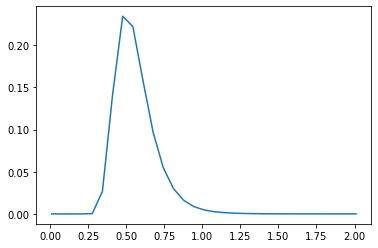

In [105]:
posterior_sigma.plot()

In [106]:
likelihood = prior3.copy()

for (slope, inter), sigmas in prior3.iterrows():
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [107]:
from utils import normalize

posterior3 = prior3 * likelihood
normalize(posterior3)
posterior3.shape

(2091, 31)

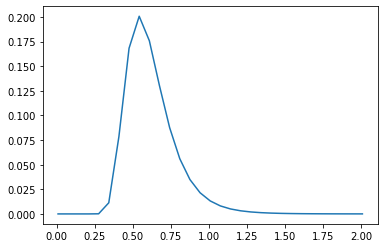

In [108]:
from utils import marginal

posterior_sigma = marginal(posterior3, 0)
posterior_sigma.plot()

In [109]:
posterior_pmf = marginal(posterior3, 1)
posterior_pmf.shape

(2091,)

In [110]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [111]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

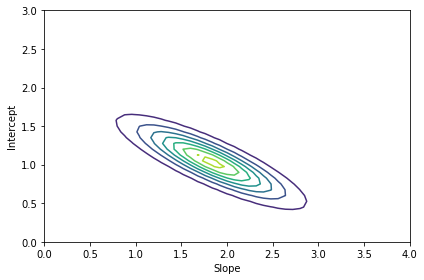

In [112]:
plot_contour(posterior_joint)

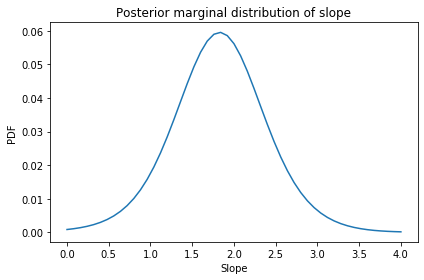

In [113]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [114]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(1.8287939808193407, array([0.88, 2.8 ]))

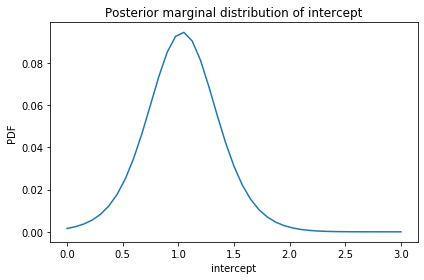

In [115]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [116]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(1.03754021069479, array([0.45 , 1.575]))

## Exercises

**Exercise:**

### The August birthday problem

This article:

[Attention Deficit–Hyperactivity Disorder and Month of School Enrollment](https://www.nejm.org/doi/10.1056/NEJMoa1806828)

Finds: 

>The rate of claims-based ADHD diagnosis among children in states with a September 1 cutoff was 85.1 per 10,000 children (309 cases among 36,319 children; 95% confidence interval [CI], 75.6 to 94.2) among those born in August and 63.6 per 10,000 children (225 cases among 35,353 children; 95% CI, 55.4 to 71.9) among those born in September, an absolute difference of 21.5 per 10,000 children (95% CI, 8.8 to 34.0); the corresponding difference in states without the September 1 cutoff was 8.9 per 10,000 children (95% CI, −14.9 to 20.8). The rate of ADHD treatment was 52.9 per 10,000 children (192 of 36,319 children; 95% CI, 45.4 to 60.3) among those born in August and 40.4 per 10,000 children (143 of 35,353 children; 95% CI, 33.8 to 47.1) among those born in September, an absolute difference of 12.5 per 10,000 children (95% CI, 2.43 to 22.4). These differences were not observed for other month-to-month comparisons, nor were they observed in states with non-September cutoff dates for starting kindergarten. In addition, in states with a September 1 cutoff, no significant differences between August-born and September-born children were observed in rates of asthma, diabetes, or obesity.

It includes this figure:

![](https://www.nejm.org/na101/home/literatum/publisher/mms/journals/content/nejm/2018/nejm_2018.379.issue-22/nejmoa1806828/20190131/images/img_xlarge/nejmoa1806828_f1.jpeg)

However, there is an error in this figure, confirmed by personal correspondence:

>The May and June [diagnoses] are reversed. May should be 317 (not 287) and June should be 287 (not 317).


Based on this corrected data, what can we say about the probability of diagnosis as a function of birth month?

What can we say about the rate of misdiagnosis?

In [117]:
n = np.array([32690, 31238, 34405, 34565, 34977, 34415, 
                   36577, 36319, 35353, 34405, 31285, 31617])

k = np.array([265, 280, 307, 312, 317, 287, 
                      320, 309, 225, 240, 232, 243])

In [118]:
x = np.arange(12)
n = np.roll(n, -8)
k = np.roll(k, -8)

In [119]:
data = pd.DataFrame(dict(x=x, k=k, n=n))
data['rate'] = data['k'] / data['n'] * 10000
data

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719
8,8,317,34977,90.630986
9,9,287,34415,83.393869


In [120]:
def plot_data(data):
    plt.plot(data['x'], data['rate'], 'o', 
         color='C1', alpha=0.5)
    decorate(xlabel='Birth date, months after cutoff',
             ylabel='Diagnosis rate per 10,000')

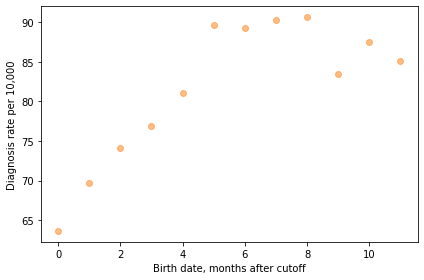

In [121]:
plot_data(data)

For the first 9 months, from September to May, we see what we would expect if at least some of the excess diagnoses are due to behavioral differences due to age.  For each month of difference in age, we see an increase in the number of diagnoses.

This pattern breaks down for the last three months, June, July, and August.  This might be explained by random variation, but it also might be due to parental manipulation; if some parents hold back students born near the deadline, the observations for these month would include a mixture of children who are relatively old for their grade, and therefore less likely to be diagnosed.

We could test this hypothesis by checking the actual ages of these students when they started school, rather than just looking at their months of birth.


In [122]:
inter = -5
slope = 0.01

In [123]:
xs = data['x']
ps = expit(inter + slope * xs)
ps

0     0.006693
1     0.006760
2     0.006827
3     0.006895
4     0.006964
5     0.007034
6     0.007104
7     0.007175
8     0.007246
9     0.007319
10    0.007392
11    0.007465
Name: x, dtype: float64

In [124]:
rate = ps * 10000

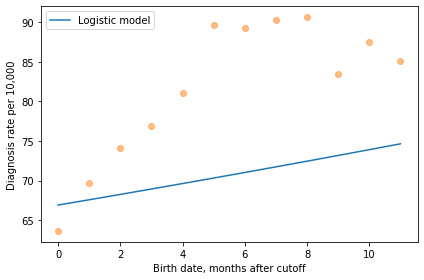

In [125]:
rate.plot(color='C0', label='Logistic model')

plot_data(data)

In [126]:
from scipy.stats import binom

ks = data['k']
ns = data['n']
likes = binom.pmf(ks, ns, ps)

In [127]:
likes.prod()

1.102452623753274e-39

In [128]:
inters = np.linspace(-5.2, -4.6, 51)
prior_inter = Pmf(1.0, inters)
prior_inter.index.name = 'Intercept'

In [129]:
slopes = np.linspace(0.0, 0.08, 51)
prior_slope = Pmf(1.0, slopes)
prior_slope.index.name = 'Slope'

In [130]:
joint = make_joint(prior_inter, prior_slope)
joint.head()

Intercept,-5.200,-5.188,-5.176,-5.164,-5.152,-5.140,-5.128,-5.116,-5.104,-5.092,...,-4.708,-4.696,-4.684,-4.672,-4.660,-4.648,-4.636,-4.624,-4.612,-4.600
Slope,,,,,,,,,,,,,,,,,,,,,
0.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0032,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0048,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0.0064,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [131]:
joint_pmf = Pmf(joint.stack())
joint_pmf.head()

Slope  Intercept
0.0    -5.200       1.0
       -5.188       1.0
       -5.176       1.0
       -5.164       1.0
       -5.152       1.0
dtype: float64

In [132]:
num_legit = 7
data1 = data.loc[0:num_legit]
data2 = data.loc[num_legit+1:]
data1

,x,k,n,rate
0,0,225,35353,63.643821
1,1,240,34405,69.757303
2,2,232,31285,74.156944
3,3,243,31617,76.857387
4,4,265,32690,81.064546
5,5,280,31238,89.634420
6,6,307,34405,89.231216
7,7,312,34565,90.264719


In [133]:
data2

,x,k,n,rate
8,8,317,34977,90.630986
9,9,287,34415,83.393869
10,10,320,36577,87.486672
11,11,309,36319,85.079435


In [134]:
likelihood1 = joint_pmf.copy()

xs = data1['x']
ks = data1['k']
ns = data1['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.pmf(ks, ns, ps)
    likelihood1.loc[slope, inter] = likes.prod()

In [135]:
likelihood1.sum()

4.136745938719928e-12

In [136]:
likelihood2 = joint_pmf.copy()

xs = data2['x']
ks = data2['k']
ns = data2['n']

for slope, inter in joint_pmf.index:
    ps = expit(inter + slope * xs)
    likes = binom.sf(ks, ns, ps)
    likelihood2.loc[slope, inter] = likes.prod()

In [137]:
likelihood2.sum()

1683.6808206806263

In [138]:
posterior_pmf = joint_pmf * likelihood1
posterior_pmf.normalize()

4.136745938719928e-12

In [139]:
posterior_pmf.max_prob()

(0.049600000000000005, -5.008)

In [140]:
posterior_pmf = joint_pmf * likelihood1 * likelihood2
posterior_pmf.normalize()

3.6151340714493297e-12

In [141]:
posterior_pmf.max_prob()

(0.0528, -5.02)

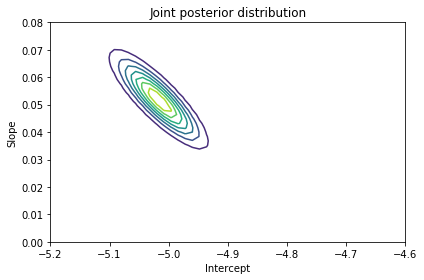

In [142]:
joint_posterior = posterior_pmf.unstack()

plot_contour(joint_posterior)
decorate(title='Joint posterior distribution')

In [143]:
marginal_inter = marginal(joint_posterior, 0)
marginal_slope = marginal(joint_posterior, 1)

marginal_inter.mean(), marginal_slope.mean()

(-5.01743458755419, 0.05194281830277113)

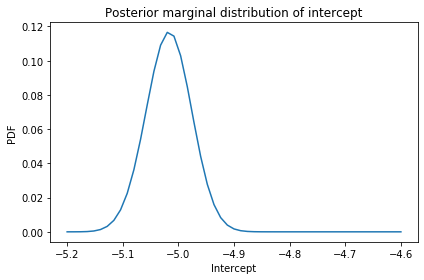

In [144]:
marginal_inter.plot()
decorate(xlabel='Intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

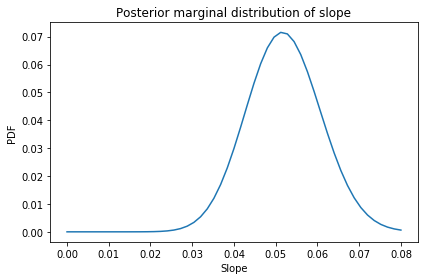

In [145]:
marginal_slope.plot()

decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [146]:
sample = posterior_pmf.sample(101)
xs = data['x']
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter) in enumerate(sample):
    pred[i] = expit(inter + slope * xs)
    
pred.shape

(101, 12)

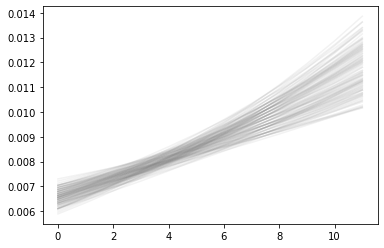

In [147]:
for ps in pred:
    plt.plot(xs, ps, color='gray', alpha=0.1)

In [148]:
low, median, high = np.percentile(pred, [2.5, 50, 97.5], axis=0)
median

array([0.00656119, 0.00693648, 0.00731563, 0.00769698, 0.0081238 ,
       0.00856049, 0.0090491 , 0.00954261, 0.01007073, 0.01056069,
       0.01116217, 0.0116861 ])

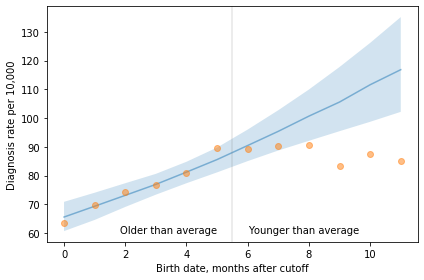

In [149]:
plt.fill_between(xs, low*10000, high*10000, alpha=0.2)
plt.plot(xs, median*10000, alpha=0.5)

plt.axvline(5.5, color='gray', alpha=0.2)
plt.text(6, 60, 'Younger than average')
plt.text(5, 60, 'Older than average', horizontalalignment='right')

plot_data(data)

## Censored regression

In [150]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 166)

In [151]:
gss.groupby('year')['realinc'].max()

year
1972    109355.000000
1973     93210.000000
1974     94738.000000
1975     86496.000000
1976     79340.000000
1977    162607.000000
1978    143778.000000
1980    128141.000000
1982     90722.000000
1983    110895.000000
1984     92858.000000
1985     99257.000000
1986    102084.000000
1987     90278.000000
1988     91587.000000
1989     88133.000000
1990     99988.000000
1991     90265.000000
1993    103880.000000
1994     99956.000000
1996    102565.000000
1998    115841.000000
2000    141038.000000
2002    137237.765625
2004    128434.609375
2006    144502.718750
2008    146153.671875
2010    119606.062500
2012    155139.968750
2014    134817.437500
2016    131676.687500
2018    119879.414062
Name: realinc, dtype: float32

In [152]:
gss['rincome'].value_counts()

12.0    14957
9.0      4876
11.0     3838
10.0     3838
2.0      1865
8.0      1745
1.0      1306
3.0      1243
5.0      1091
4.0      1055
6.0       993
7.0       981
Name: rincome, dtype: int64

In [153]:
valid = gss.dropna(subset=['rincome', 'realinc'])
valid.shape

(36916, 166)

In [154]:
for name, group in valid.groupby('year'):
    print(name, len(group))
    plt.plot(group['income'], group['realinc'], 'o', alpha=0.3)
    break

1974 826


KeyError: 'income'

In [ ]:
valid = gss.dropna(subset=['realinc', 'polviews'])
valid.shape

In [ ]:
plt.plot(valid['realinc'], valid['polviews'], ',', alpha=0.3)

## Marathon world record

In [155]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

In [156]:
table = tables[0]
table.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes
0,2:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom",IAAF[53],Time was officially recorded as 2:55:18 2/5.[5...
1,2:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5] United States",IAAF[53],Note.[56]
2,2:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States",IAAF[53],Note.[56]
3,2:46:04.6,Albert Raines,United States,"May 8, 1909","New York City, United States",IAAF[53],Note.[56]
4,2:42:31.0,Henry Barrett,United Kingdom,"May 26, 1909[nb 6]","Polytechnic Marathon, London, United Kingdom",IAAF[53],Note.[56]


In [157]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date']

0    1908-07-24
1    1909-01-01
2    1909-02-12
3    1909-05-08
4           NaT
5    1909-08-31
6    1913-05-12
7    1913-05-31
8    1914-11-29
9    1920-08-22
10   1925-10-12
11   1929-07-05
12   1935-03-21
13   1935-03-31
14   1935-04-03
15   1935-11-03
16   1947-04-19
17   1952-06-14
18   1953-06-13
19   1953-10-04
20   1954-06-26
21   1956-08-12
22   1958-08-24
23   1960-09-10
24   1963-02-17
25   1963-06-15
26   1963-07-06
27   1964-06-13
28   1964-10-21
29   1965-06-12
30   1967-12-03
31   1969-05-30
32   1970-07-23
33   1974-01-31
34   1978-02-05
35   1980-04-26
36   1981-12-06
37   1984-10-21
38   1985-04-20
39   1988-04-17
40   1998-09-20
41   1999-10-24
42   2002-04-14
43   2003-09-28
44   2007-09-30
45   2008-09-28
46   2011-09-25
47   2013-09-29
48   2014-09-28
49   2018-09-16
Name: date, dtype: datetime64[ns]

In [158]:
table['date'].dt

In [159]:
table['time'] = pd.to_timedelta(table['Time'])

In [160]:
table['mph'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['mph']

0      8.967143
1      9.099504
2      9.419942
3      9.465508
4      9.672854
5      9.790123
6      9.932394
7     10.069823
8      9.948528
9     10.301667
10    10.548212
11    10.413355
12    10.749943
13    10.634795
14    10.713312
15    10.715746
16    10.792997
17    11.172443
18    11.335993
19    11.343628
20    11.419716
21    11.384705
22    11.620057
23    11.621202
24    11.621775
25    11.690630
26    11.668935
27    11.738643
28    11.892274
29    11.909091
30    12.129006
31    12.227754
32    12.140871
33    12.167183
34    12.177236
35    12.184472
36    12.252533
37    12.273260
38    12.358491
39    12.394218
40    12.467944
41    12.505967
42    12.512603
43    12.584390
44    12.633271
45    12.679124
46    12.715018
47    12.740781
48    12.785685
49    12.922318
Name: mph, dtype: float64

In [161]:
def plot_speeds(df):
    plt.axhline(13.1, color='gray')
    plt.plot(df['date'], df['mph'], 'o', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

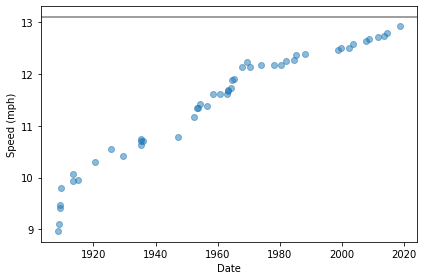

In [162]:
plot_speeds(table)

In [163]:
recent = table['date'] > pd.to_datetime('1970')

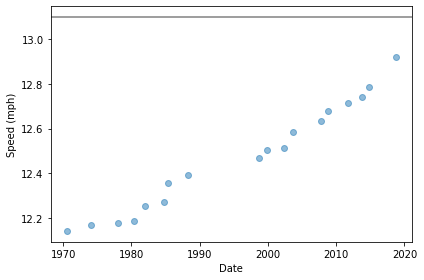

In [164]:
data = table.loc[recent].copy()
plot_speeds(data)

In [165]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data['x'].describe()

count    18.000000
mean      0.740913
std      15.417918
min     -24.444201
25%     -12.352152
50%       4.264319
75%      13.492498
max      23.707699
Name: x, dtype: float64

In [166]:
import statsmodels.formula.api as smf

formula = 'mph ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mph   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     530.7
Date:                Sat, 01 Aug 2020   Prob (F-statistic):           1.07e-13
Time:                        14:02:51   Log-Likelihood:                 32.294
No. Observations:                  18   AIC:                            -60.59
Df Residuals:                      16   BIC:                            -58.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4605      0.010   1237.317      0.000      12.439      12.482
x              0.0155      0.001     23.037      0.000       0.014       0.017
==============================================================================
Omnibus:                        1.748   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.174
Skew:                           0.612   Prob(JB):                        0.556
Kurtosis:                       2.745   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
slopes = np.linspace(0.01, 0.02, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [168]:
inters = np.linspace(12.4, 12.6, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [169]:
sigmas = np.linspace(0.01, 0.31, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [170]:
joint = make_joint(prior_slope, prior_inter)
joint.shape

(41, 51)

In [171]:
joint_pmf = Pmf(joint.transpose().stack())
joint_pmf.head()

Slope  Intercept
0.01   12.400       1
       12.405       1
       12.410       1
       12.415       1
       12.420       1
dtype: int64

In [172]:
prior3 = make_joint(prior_sigma, joint_pmf)
prior3.shape

(2091, 31)

In [173]:
from scipy.stats import norm

xs = data['x']
ys = data['mph']

likelihood = prior3.copy()

for (slope, inter), sigmas in prior3.iterrows():
    resid = slope * xs + inter - ys
    sigma_mesh, resid_mesh = np.meshgrid(prior_sigma.index, resid)
    densities = norm.pdf(resid_mesh, 0, sigma_mesh)
    like = densities.prod(axis=0)
    likelihood.loc[slope, inter] = like

In [174]:
from utils import normalize

posterior3 = prior3 * likelihood
normalize(posterior3)
posterior3.shape

(2091, 31)

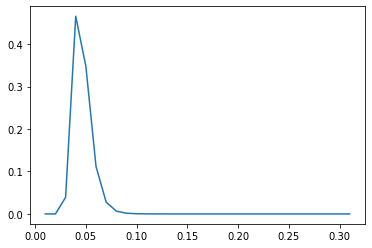

In [175]:
from utils import marginal

posterior_sigma = marginal(posterior3, 0)
posterior_sigma.plot()

In [176]:
posterior_pmf = marginal(posterior3, 1)
posterior_pmf.shape

(2091,)

In [177]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

In [178]:
def plot_contour(joint, **options):
    """Plot a joint distribution.
    
    joint: DataFrame representing a joint PMF
    """
    cs = plt.contour(joint.columns, joint.index, joint, **options)
    decorate(xlabel=joint.columns.name, 
             ylabel=joint.index.name)
    return cs

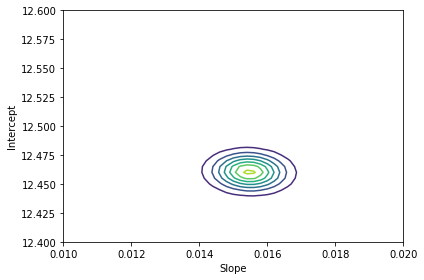

In [179]:
plot_contour(posterior_joint)

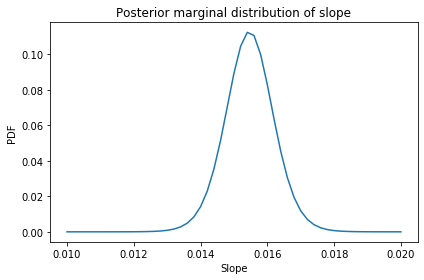

In [180]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [181]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.015464394668292185, array([0.0142, 0.0166]))

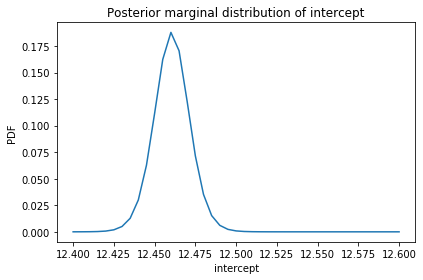

In [182]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [183]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(12.460507580847914, array([12.44, 12.48]))

In [184]:
posterior_pmf = Pmf(posterior3.stack())
posterior_pmf.head()

Slope  Intercept  Sigma
0.01   12.4       0.01      0.000000e+00
                  0.02     2.651660e-115
                  0.03      1.140654e-50
                  0.04      3.462615e-29
                  0.05      6.013886e-20
dtype: float64

In [185]:
sample = posterior_pmf.sample(101)
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 38)

In [187]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(38,)

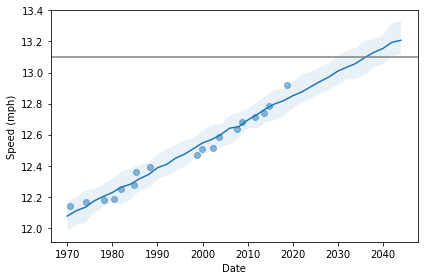

In [190]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, alpha=0.1)
plt.plot(times, median, color='C0')

plot_speeds(data)

In [189]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

pd.to_timedelta(future*365.24, unit='day') + offset

DatetimeIndex([   '2029-08-10 15:41:20.272704',
               '2036-03-17 10:24:35.436758400',
               '2041-10-08 03:04:39.181468800'],
              dtype='datetime64[ns]', freq=None)